# Lotka-Volterra

How efficient are the solvers on a simple benchmark problem?

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.integrate
from diffeqzoo import backend, ivps
from jax import config

from probdiffeq import controls, ivpsolvers
from probdiffeq.doc_util import benchmark, info, notebook, workprecision
from probdiffeq.implementations import recipes
from probdiffeq.strategies import filters

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

# Which version of the softwares are we using?
info.print_info()


ProbDiffEq version:
	0.1.2.dev4+dirty
Diffrax version:
	0.3.1
SciPy version:
	1.10.1

Most recent ProbDiffEq commit:
	b'180af9\n'

jax:    0.4.4
jaxlib: 0.4.4
numpy:  1.24.2
python: 3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 50.0))


@jax.jit
def vf(x, *, t, p=()):
    return f(x, *f_args)


problem = benchmark.FirstOrderIVP(vector_field=vf, initial_values=(u0,), t0=t0, t1=t1)
problem_jax = problem.to_jax(t=jnp.asarray([t0, t1]))
problem_scipy = problem.to_scipy(t_eval=[t0, t1])
problems = {"probdiffeq": problem, "jax": problem_jax, "scipy": problem_scipy}

# Compute a reference solution
scipy_solution = scipy.integrate.solve_ivp(
    *problem_scipy.args,
    atol=1e-13,
    rtol=1e-13,
)

# Select all remaining problem parameters
rtols = 0.1 ** jnp.arange(3.0, 11.0, step=1.0)
atols = 1e-2 * rtols
num_repeats = 5
error_fn = benchmark.relative_rmse(solution=scipy_solution.y.T[-1, :])
solve_fn = benchmark.probdiffeq_terminal_values()
solve_fn_jax = benchmark.jax_terminal_values()
solve_fn_scipy = benchmark.scipy_terminal_values()
solve_fns = {"probdiffeq": solve_fn, "jax": solve_fn_jax, "scipy": solve_fn_scipy}

# Bundle the problem setup
problem_config = workprecision.ProblemConfig(
    label="Lotka-Volterra (terminal-value simulation)",
    problems=problems,
    error_fn=error_fn,
    solve_fns=solve_fns,
    atols=atols,
    rtols=rtols,
    repeat=num_repeats,
)

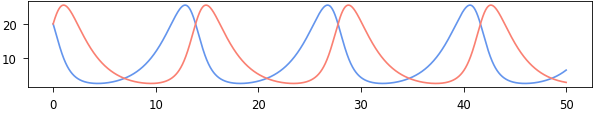

In [4]:
fig, ax = plt.subplots(figsize=(5, 1))
ax.plot(scipy_solution.t, scipy_solution.y.T, marker="None")
plt.show()

In [5]:
# Some helper functions


def impl_to_method_config(impl, *, label):
    return strategy_to_method_config(filters.Filter(impl), label=label)


def strategy_to_method_config(strategy, *, label):
    solver = ivpsolvers.MLESolver(strategy)
    return workprecision.MethodConfig(
        method=solver_to_method(solver),
        label="ProbDiffEq: " + label,
        key="probdiffeq",
        jit=True,
        plotting_kwargs={"color": "C0"},
    )


def solver_to_method(solver):
    return {
        "solver": solver,
        "control": controls.ProportionalIntegral(),
    }


def jax_method_config():
    return workprecision.MethodConfig(
        method={},
        label="JAX: Dormand-Prince",
        jit=True,
        tols_static=True,
        key="jax",
        plotting_kwargs={"color": "C1"},
    )


def scipy_method_config(method):
    return workprecision.MethodConfig(
        method={"method": method},
        label="SciPy: " + method,
        jit=False,
        key="scipy",
        plotting_kwargs={"color": "C2"},
    )

In [6]:
# Implementations
num_low, num_medium, num_high = 3, 5, 8
ode_shape = u0.shape

ts0_iso_low = recipes.ts0_iso(num_derivatives=num_low)
ts0_iso_medium = recipes.ts0_iso(num_derivatives=num_medium)
ts1_high = recipes.ts1_dense(ode_shape=ode_shape, num_derivatives=num_high)
slr1_high = recipes.slr1_dense(ode_shape=ode_shape, num_derivatives=num_high)

# Methods
methods = [
    scipy_method_config(method="RK45"),
    scipy_method_config(method="DOP853"),
    jax_method_config(),
    impl_to_method_config(ts0_iso_low, label=f"IsoTS0({num_low})"),
    impl_to_method_config(ts0_iso_medium, label=f"IsoTS0({num_medium})"),
    impl_to_method_config(ts1_high, label=f"DenseTS1({num_high})"),
    impl_to_method_config(slr1_high, label=f"DenseSLR1({num_high})"),
]

In [7]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

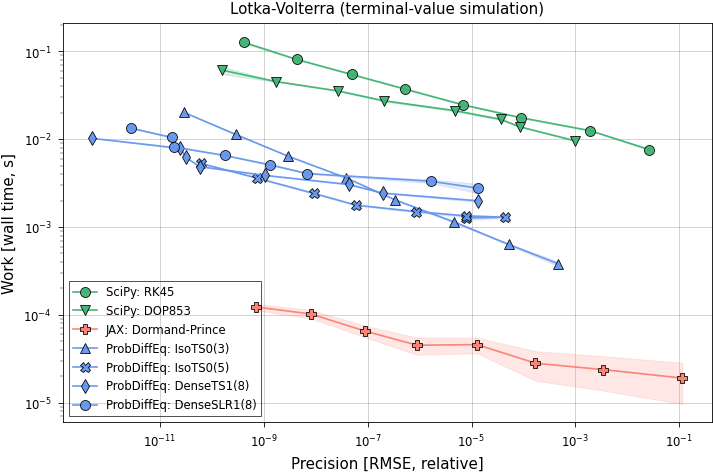

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
fig, ax = workprecision.plot(
    results=results, fig=fig, ax=ax, title=problem_config.label
)
plt.show()